# Анализ рекламных кампаний для рекламодателя "Сигма"

Исследование проводится по инициативе компании "Сигма", так как в последние 4 месяца (с июня по сентябрь 2022 года) наблюдается рост показателя CPA по рекламным кампаниям. Входные данные были предоставлены в формате таблицы excel.

__Описание данных__

* `Client` - название клиента
* `Device` - тип устройства
* `Place` - тип площадки
* `BannerType` - тип объявления
* `QueryType` - тип запроса
* `TargetingType` - тип таргетинга
* `Cost` - расходы рекламодателя
* `Conversions` - целевые визиты

__Декомпозиция проекта__
_Открыть файл с данными и изучить общую информацию_
- Открыть файлы,
- Получить информацию о размерах таблиц,
- Получить информацию о типах данных,
- Проверить наличие или отсутствие пропусков,
- Изучить названия колонок.

_Подготовить данные к анализу_
- Изменить названия столбцов,
- Изменить типы данных при необходимости,
- Обработать пропуски при необходимости,
- Проверить на наличие дубликатов, устранить при обнаружении.

_Исследовательский анализ данных_
- Создать столбцы с показателем СРА и с булевыми значениями для кампаний с показателем СРА меньше 380 рублей
- Просмотреть у каких параметров рекламы больше выбросов значения СРА
- Оценить соотношение успешных и провальных рекламных кампаний, найти убыточные параметры.

__По итогу данного исследования необходимо ответить на следующие основные вопросы заказчика:__
1. Какова причина растущего CPA?
2. Какие действия необходимо предпринять для стабилизации CPA до целевого значения в 380 руб?

## Общая информация о данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
!pip install skimpy --quiet
from skimpy import clean_columns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Читаем датасет
data = pd.read_excel(io='C:\\Users\\User\\Desktop\\Задание_стажировка_рекламный аналитик_2023.xlsx', sheet_name ='data')
data.head()

,Client,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost,Conversions
0,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,cpc_video,none,Phrase,0,0,0.000000,0
1,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,cpc_video,none,Retargeting,5949,41,1666.844364,0
2,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,cpc_video,none,Retargeting,191,6,40.641915,0
3,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,227,1,45.747407,0
4,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,18,0,0.000000,0


Названия столбцов для удобства приведем к "змеиному стилю". Столбец QueryType имеет пропуски в значениях, но есть пояснение в самом названии столбца - тип запроса размечается только для площадки поисковиков, как мобильных устройств так и компьютеров. Однако более интересно то, что даты не совпадают с интересующим нас периодом. А также в таблице присутствуют данные для других рекламодателей, нужно будет их отсечь. Есть столбцы, которые не были описаны во входных данных, например с категорией товара или услуги, количеством показов и количеством кликов.

In [3]:
# Посмотрим на общую информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10478 entries, 0 to 10477
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Client                   10478 non-null  object        
 1   Month                    10478 non-null  datetime64[ns]
 2   Category                 10478 non-null  object        
 3   Device                   10478 non-null  object        
 4   Place                    10478 non-null  object        
 5   BannerType               10478 non-null  object        
 6   QueryType (search only)  10478 non-null  object        
 7   TargetingType            10478 non-null  object        
 8   Shows                    10478 non-null  int64         
 9   Clicks                   10478 non-null  int64         
 10  Cost                     10478 non-null  float64       
 11  Conversions              10478 non-null  int64         
dtypes: datetime64[ns](1), float64(1)

Таблица у нас почти на 10,5 тысяч строк, явных пропусков нет, но мы помним о столбце с запросами, там заглушка в пустых значениях. Форматы в порядке. Предобработка займет немного времени.

## Предобработка данных

Перед тем как начать работать с таблицей, приведем все к одному стилю

In [4]:
# Приведем название столбцов к змеиному стилю и проверим
data = clean_columns(data)
data.columns

12 column names have been cleaned

Index(['client', 'month', 'category', 'device', 'place', 'banner_type',
       'query_type_search_only', 'targeting_type', 'shows', 'clicks', 'cost',
       'conversions'],
      dtype='object')

Названия столбцов в порядке, возможно теперь столбец с типами запросов слишком длинный в названии, но мы им будем пользоваться не часто, поэтому оставим так. Типы данных у нас в порядке, пропуски тоже, поэтому перейдем сразу к усечению таблицы

In [5]:
# Для начала посмотрим на начальную и конечную даты
display(data['month'].min())
display(data['month'].max())

Timestamp('2021-04-01 00:00:00')

Timestamp('2022-09-01 00:00:00')

Конечная дата совпадает с окончанием интересующего нас периода, а вот начало таблицы можно будет отсечь до июня 2022. 

In [6]:
# Срежем таблицу до четырех месяцев под условия 
data = data.query('6 <= month.dt.month <= 9 and month.dt.year == 2022')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2597 entries, 1405 to 10477
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   client                  2597 non-null   object        
 1   month                   2597 non-null   datetime64[ns]
 2   category                2597 non-null   object        
 3   device                  2597 non-null   object        
 4   place                   2597 non-null   object        
 5   banner_type             2597 non-null   object        
 6   query_type_search_only  2597 non-null   object        
 7   targeting_type          2597 non-null   object        
 8   shows                   2597 non-null   int64         
 9   clicks                  2597 non-null   int64         
 10  cost                    2597 non-null   float64       
 11  conversions             2597 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), 

В таблице остались данные за интересующий нас период, теперь перейдем к нашему клиенту "Сигма". Перед срезом проверим, нет ли дубликатов в названиях клиентов

In [7]:
# Посмотрим есть ли дубликаты в клиентах
data['client'].value_counts()

Гамма     510
Псилон    463
Сигма     366
Зета      356
Бета      254
Омега     227
Альфа     149
Лямбда    116
Дельта    102
Мета       54
Name: client, dtype: int64

Дубликатов нет, можно резать

In [8]:
# Оставим данные только по интересующему нас клиенту
data = data.query('client == "Сигма"').reset_index(drop=True)
data.head()

,client,month,category,device,place,banner_type,query_type_search_only,targeting_type,shows,clicks,cost,conversions
0,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Phrase,691662,800,27195.085297,3
1,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,62231,64,2596.608788,0
2,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Phrase,781123,4445,34841.902017,2
3,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,59842,450,6232.857686,3
4,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Phrase,33142457,32221,905710.779483,99


Итак, у нас остались только необходимые нам данные. Проверим наличие дубликатов в записях.

In [9]:
# Проверим наличие явных дубликатов
display(data.duplicated().sum())

0

Явных дубликатов необнаружено, пройдемся по столбцам, возможно есть неявные дубликаты.

In [10]:
# Ищем дубликаты в категориях
data['category'].value_counts()

ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ      79
РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ    72
ИПОТЕЧНОЕ КРЕДИТОВАНИЕ            64
КРЕДИТНЫЕ КАРТЫ                   60
ДЕБЕТОВЫЕ КАРТЫ                   51
ВКЛАДЫ                            40
Name: category, dtype: int64

Нам не было предоставлено описание данного столбца во входных данных, рискну предположить, что это тип рекламируемой услуги. Дубликатов нет.

In [11]:
# Ищем дубликаты в устройствах
data['device'].value_counts()

Desktop    184
Mobile     182
Name: device, dtype: int64

Здесь тоже все в порядке.

In [12]:
# Ищем дубликаты в типах площадки
data['place'].value_counts()

Search      210
Networks    156
Name: place, dtype: int64

Search, я так полагаю, реклама в поисковике при определенном запросе
Networks - реклама в сети на каких-то страницах.
Дубликатов нет.

In [13]:
# Ищем дубликаты в типах объявлений
data['banner_type'].value_counts()

text          302
image_ad       26
cpm_banner     26
mcbanner       12
Name: banner_type, dtype: int64

Сразу видно, что в лидерах текстовый формат рекламы. Дубликатов нет.

In [14]:
# Ищем дубликаты в типах рекламы в поисковике
data['query_type_search_only'].value_counts()

none          156
Other          76
Competitor     72
Brand          62
Name: query_type_search_only, dtype: int64

Количество пропусков у нас равно количеству рекламы на сайтах, также реклама выпадала при вводе названия компании или же названий конкурентов и при прочих запросах при ключевых словах. Дубликатов нет.

In [15]:
# Ищем дубликаты в типах таргетинга
data['targeting_type'].value_counts()

Phrase           218
Retargeting       82
Autotargeting     66
Name: targeting_type, dtype: int64

В типах таргетинга дубликатов нет.

## Исследовательский анализ данных

### Создание новых столбцов для исследования

Сразу бросаются в глаза рекламные кампании, в которых вообще не было показов. Либо был сбой в сборе данных, либо кампании так и не вышли в свет. Так или иначе, если не было показов и кликов, то не потратили и деньги ни эти кампании. Пустые данные, которые нам не подскажут в чем причина увеличения CPA. Избавимся от них. Но сначала посмотрим на динамику количества таких пустышек и сравним с количеством остальных кампаний.

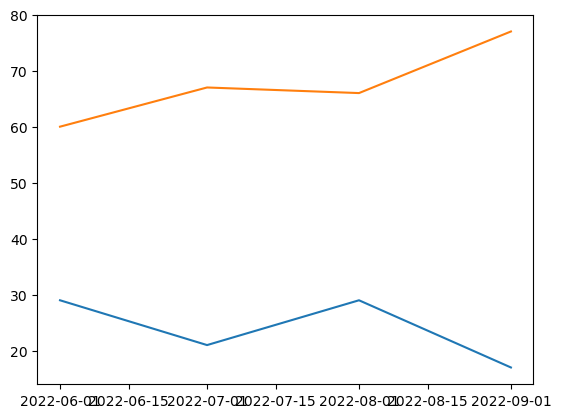

In [16]:
# Отбираем пустые строки и посмотрим как менялось их количество во времени
plt.plot(data.query('cost == 0').pivot_table(index='month', values='client', aggfunc='count'))
plt.plot(data.query('cost != 0').pivot_table(index='month', values='client', aggfunc='count'));

Графики зеркалят друг друга. Заметна обратная пропорциональность. Чем больше пустышек тем меньше реальных кампаний. Все же наблюдается тенденция к снижению количества пустых кампаний. Избавляемся от пустых.

In [17]:
# Исключаем из таблицы строки с нулевой стоимостью
data = data.query('cost != 0').reset_index(drop=True)
data.head()

,client,month,category,device,place,banner_type,query_type_search_only,targeting_type,shows,clicks,cost,conversions
0,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Phrase,691662,800,27195.085297,3
1,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,62231,64,2596.608788,0
2,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Phrase,781123,4445,34841.902017,2
3,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,59842,450,6232.857686,3
4,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Phrase,33142457,32221,905710.779483,99


У нас все же остались строки с нулевой конверсией. Но так как показы и клики были, деньги на рекламу уходили. Пропущенные значения в CPA нужно будет заглушить общей стоимостью кампании. Добавим столбец с рассчитанным CPA, поставим заглушки и продолжим.

In [18]:
# Рассчитываем показатель СРА и считаем сколько у нас пустых значений
data['cpa'] = round(data['cost'] / data['conversions'], 2)
sum(data['conversions'] == 0)

28

In [19]:
# Заменяем показатель СРА с пропуском на общую стоимость кампании
data.loc[data['conversions'] == 0, 'cpa'] = data['cost']
data.head()

,client,month,category,device,place,banner_type,query_type_search_only,targeting_type,shows,clicks,cost,conversions,cpa
0,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Phrase,691662,800,27195.085297,3,9065.030000
1,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,62231,64,2596.608788,0,2596.608788
2,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Phrase,781123,4445,34841.902017,2,17420.950000
3,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,59842,450,6232.857686,3,2077.620000
4,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Phrase,33142457,32221,905710.779483,99,9148.590000


Показатель рассчитан, можно идти дальше. и создать столбец с булевыми значениями для успешных кампаний, у которых СРА меньше 380 рублей. 

In [20]:
# Добавим столбец, чтобы посчитать количество успешных кампаний
data['success'] = data['cpa'] <= 380
data

,client,month,category,device,place,banner_type,query_type_search_only,targeting_type,shows,clicks,cost,conversions,cpa,success
0,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Phrase,691662,800,27195.085297,3,9065.030000,False
1,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,62231,64,2596.608788,0,2596.608788,False
2,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Phrase,781123,4445,34841.902017,2,17420.950000,False
3,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,59842,450,6232.857686,3,2077.620000,False
4,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Phrase,33142457,32221,905710.779483,99,9148.590000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Сигма,2022-09-01,ВКЛАДЫ,Desktop,Search,text,Brand,Phrase,1003,214,2745.924153,8,343.240000,True
266,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Networks,text,none,Phrase,399500,7921,59133.506136,232,254.890000,True
267,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Networks,text,none,Retargeting,47139,1132,4998.836542,31,161.250000,True
268,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Search,text,Brand,Phrase,10590,2991,17404.488559,74,235.200000,True


### Влияние выбросов СРА

Рискну предположить, что на увеличение СРА влияют выбросы - провальные кампании, когда клики были, а конверсия не случилась, они и выдали такой рост. Посмотрим сначала на общие свойсва рассчитанного нами показателя.

In [21]:
# Рассмотрим показатели для столбца с СРА
data['cpa'].describe()

count       270.000000
mean       6666.631587
std       32722.397919
min           3.415398
25%         195.842500
50%         441.060000
75%        1988.550000
max      384782.040000
Name: cpa, dtype: float64

Средний показатель СРА очень сильно отличается от медианного. Значит точно тут побывали выбросы. Однако, и медианное значение выше пороговых 380 рублей, указанных заказчиком. Медианное значение показателя превышет порог в 380 рублей больше чем на 60 рублей.

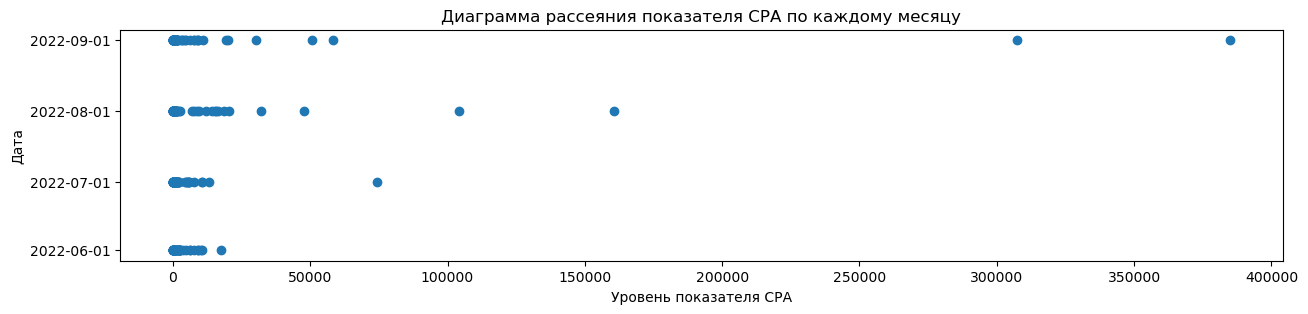

In [22]:
# Строим общую диаграмму рассеяния по каждому месяцу
plt.figure(figsize=(15,3))
plt.scatter(data['cpa'], data['month'])
plt.yticks(['2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01'])
plt.xlabel('Уровень показателя СРА')
plt.ylabel('Дата')
plt.title('Диаграмма рассеяния показателя СРА по каждому месяцу');

Как видно на диаграмме, явные выбросы начали появляться уже с июля, в сентябре же провальных компаний стало намного больше, что и вызвало рост показателя СРА. В одной из них ушло на ветер почти 400 тысяч.

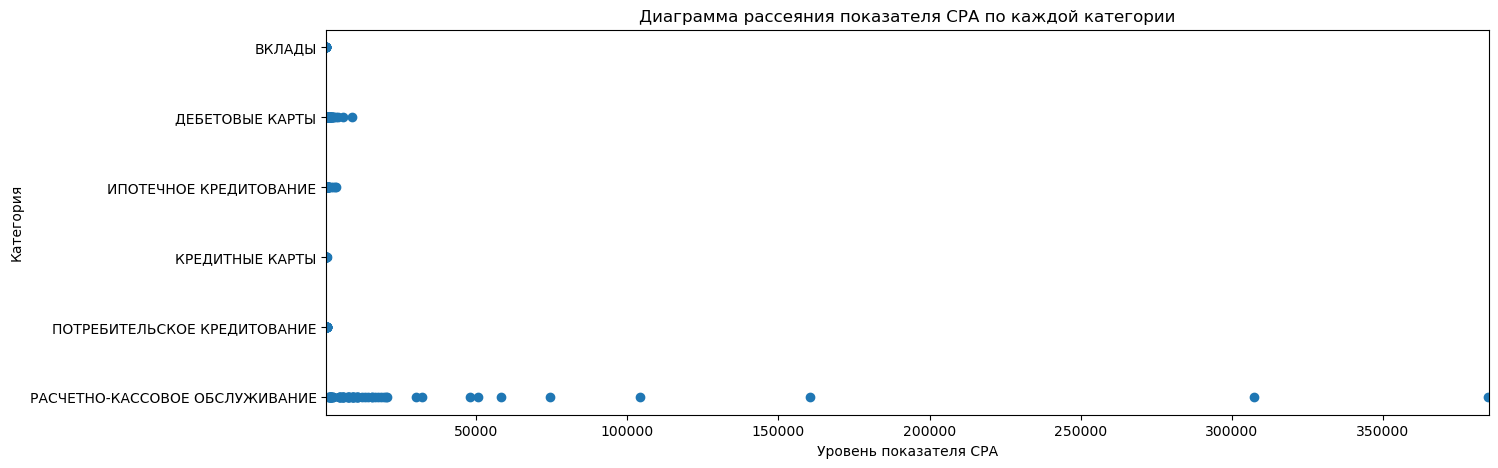

In [23]:
# Строим диаграмму рассеяния по категориям рекламируемых продуктов и услуг
plt.figure(figsize=(15,5))
plt.scatter(data['cpa'], data['category'])
plt.xlabel('Уровень показателя СРА')
plt.ylabel('Категория')
plt.xlim(380, 385000)
plt.title('Диаграмма рассеяния показателя СРА по каждой категории');

Самое большое количество неудачных кампаний было для расчетно-кассового обслуживания, далее будут идти дебетовые карты и ипотечное кредитование. Несовсем понятно, как будут конвертироваться в целевое действие именно для рассчетно-кассового обслуживания. это все же больше ассоциируется с походом в банк ногами.

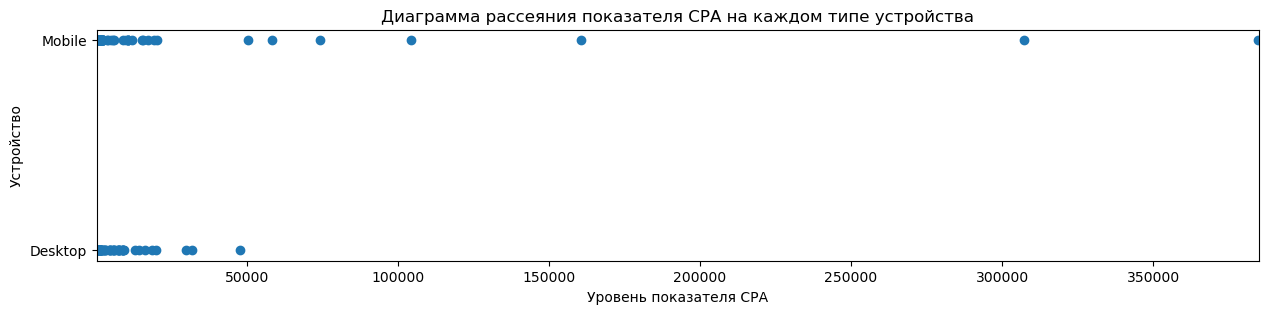

In [24]:
# Посмотрим на каких устройствах больше провальных кампаний
plt.figure(figsize=(15,3))
plt.scatter(data['cpa'], data['device'])
plt.xlabel('Уровень показателя СРА')
plt.ylabel('Устройство')
plt.xlim(380, 385000)
plt.title('Диаграмма рассеяния показателя СРА на каждом типе устройства');

Самые крупные фейлы были выпущены для мобильных устройств.

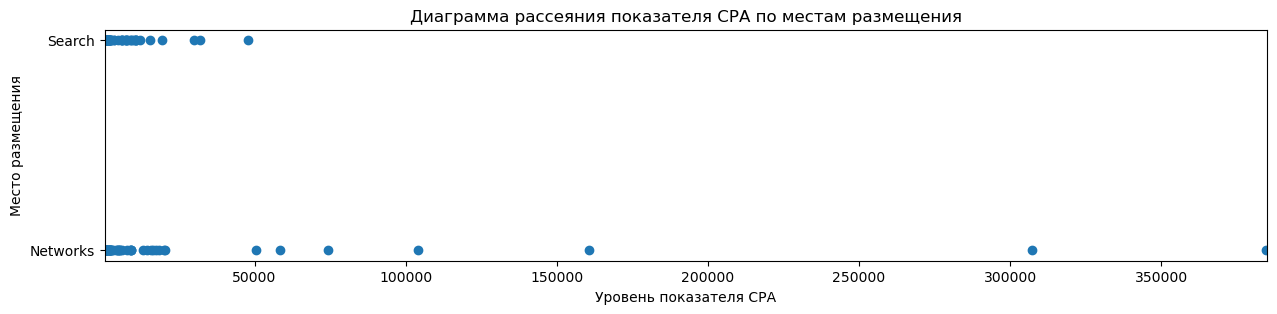

In [25]:
# Посмотрим, где по размещению больше выбросов 
plt.figure(figsize=(15,3))
plt.scatter(data['cpa'], data['place'])
plt.xlabel('Уровень показателя СРА')
plt.ylabel('Место размещения')
plt.xlim(380, 385000)
plt.title('Диаграмма рассеяния показателя СРА по местам размещения');

Самые крупные провалы были у объявлений выставленных на конкретных сайтах. Размещение в поисковике выдало меньше провальных кампаний. Возможно объявление на каком-то из сайтов было размещено как-то так, что случались случайные клики, по факту клик был, оплата с клиента взята, а толку не было, человек моментально вышел. В данной таблице явно у нас данных не хватает, тут нужно проводить дополнительные исследования. 

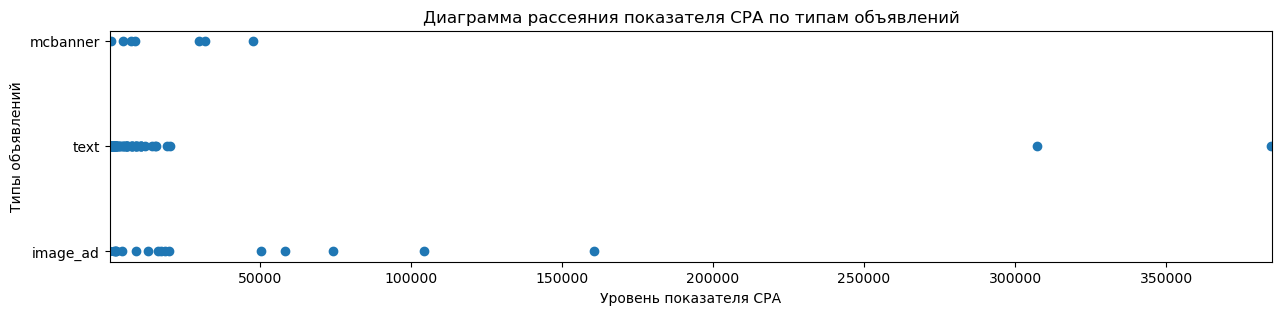

In [26]:
# Рассмотрим как распределились выбросы по типам объявлений
plt.figure(figsize=(15,3))
plt.scatter(data['cpa'], data['banner_type'])
plt.xlabel('Уровень показателя СРА')
plt.ylabel('Типы объявлений')
plt.xlim(380, 385000)
plt.title('Диаграмма рассеяния показателя СРА по типам объявлений');

Вот тут лидеров двое это и текстовые объявления и изображения. Здесь явного влияния нет.

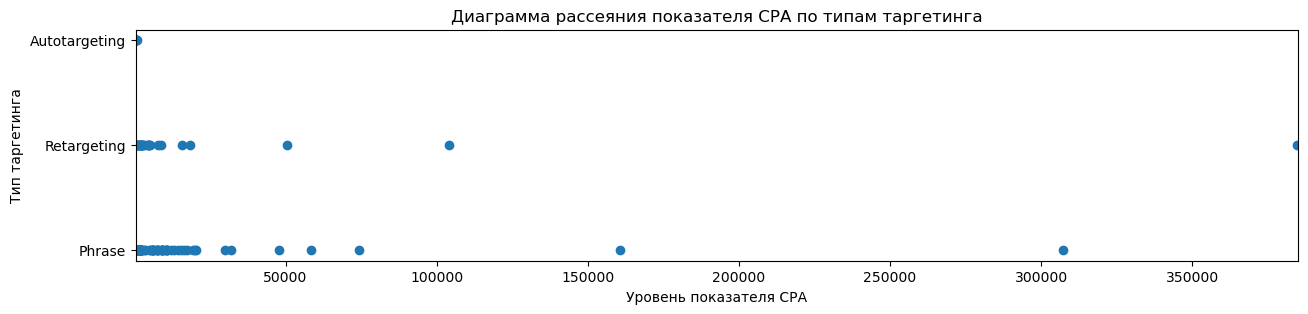

In [27]:
# Рассмотрим выбросы по типам таргетинга
plt.figure(figsize=(15,3))
plt.scatter(data['cpa'], data['targeting_type'])
plt.xlabel('Уровень показателя СРА')
plt.ylabel('Тип таргетинга')
plt.xlim(380, 385000)
plt.title('Диаграмма рассеяния показателя СРА по типам таргетинга');

Видим, что автотаргетинг был хорошо настроен и не привел к потерям, однако ретаргетинг и поиск по фразам часто давал осечки. Все же склоняюсь больше к неудачному расположению рекламы и случайным кликам. Это требует дополнительных исследований, возможны также неверные настройки таргетинга.

### Соотношение успешных и провальных категорий по различным параметрам

Об успешности того или иного параметра можно судить только при сравнении количества провальных и успешных кампаний с его участием. Поэтому рассмотрим каждый столбец.

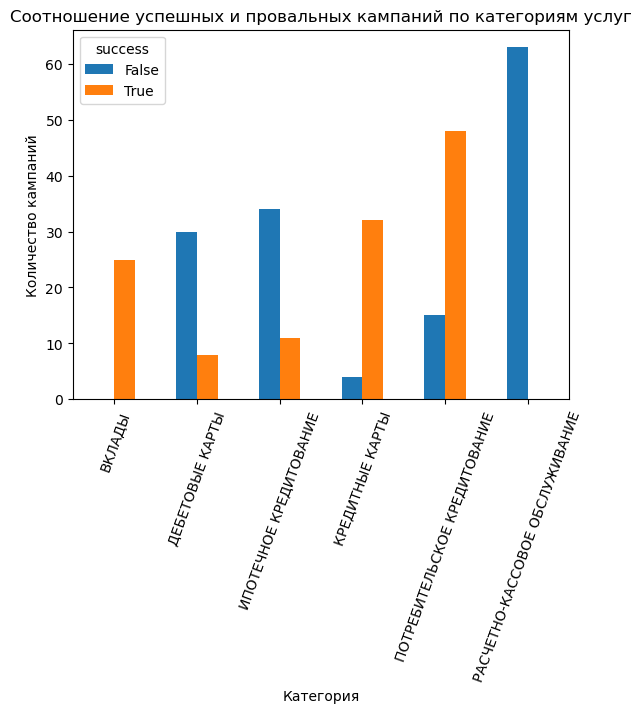

In [28]:
# Строим график соотношения кампаний по категориям услуг
data.pivot_table(index='category', columns='success', values='client', aggfunc='count')\
    .plot(kind='bar')
plt.xlabel('Категория')
plt.ylabel('Количество кампаний')
plt.title('Соотношение успешных и провальных кампаний по категориям услуг')
plt.xticks(rotation=70);

Как видно из графика, категория с расчетно-кассовым обслуживанием это абсолютно убыточная для рекламы услуга, с самого начала казалась странной, так как больше ассоциируется с походом в банк вживую, а не онлайн. Непонятно как сюда попала и как считать конверсию если человек реально пришел в банк. Также неоправдали ожиданий и категории с дебетовыми картами и ипотечным кредитованием. Следует пересмотреть включение рекламы по этим категориям в дальнейшем, одну исключить точно.

Text(0.5, 1.0, 'Количество кампаний по категории Рассчетно-кассового обслуживания')

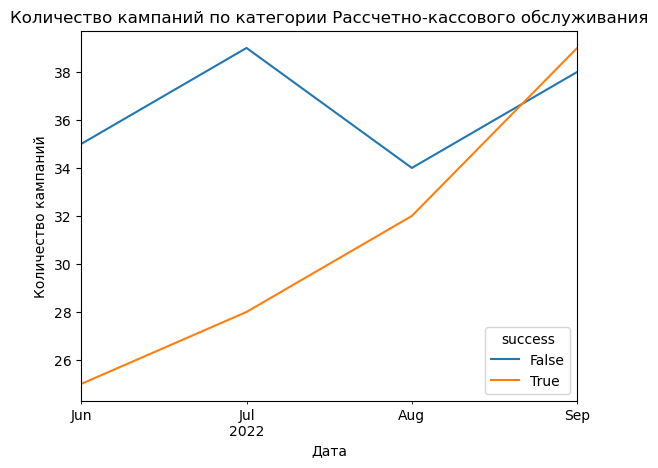

In [29]:
# Ради интереса посмотрим сколько провальных и успешных кампаний было в каждом месяце
data.pivot_table(index='month', columns='success', values='client', aggfunc='count')\
    .plot()
plt.xlabel('Дата')
plt.ylabel('Количество кампаний')
plt.title('Количество кампаний по категории Рассчетно-кассового обслуживания')

Стоит отдать должное, количество успешных кампаний неизменно увеличивалось, однако провальные были почти все время в большем количестве, только в сентябре количество успешных перекрыло провальные, но тут еще нужно смотреть и на суммы.

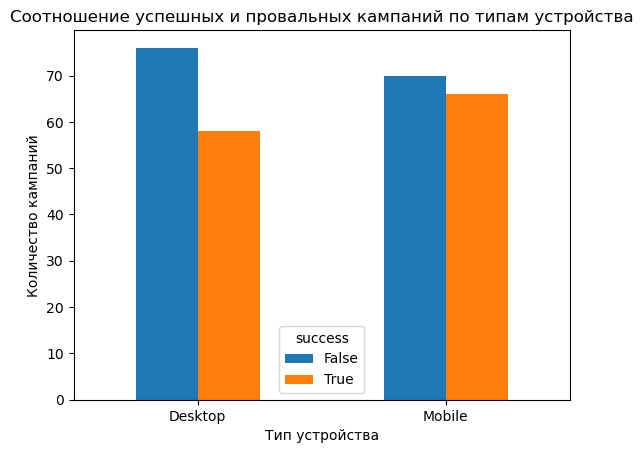

In [30]:
# Строим график соотношения кампаний по типу устройства
data.pivot_table(index='device', columns='success', values='client', aggfunc='count')\
    .plot(kind='bar')
plt.xlabel('Тип устройства')
plt.ylabel('Количество кампаний')
plt.title('Соотношение успешных и провальных кампаний по типам устройства')
plt.xticks(rotation=0);

Чуть лучше реклама шла на мобильных устройствах, разница же между провальными и успешными кампаниями для компьютеров более ощутима, они чаще проваливались.

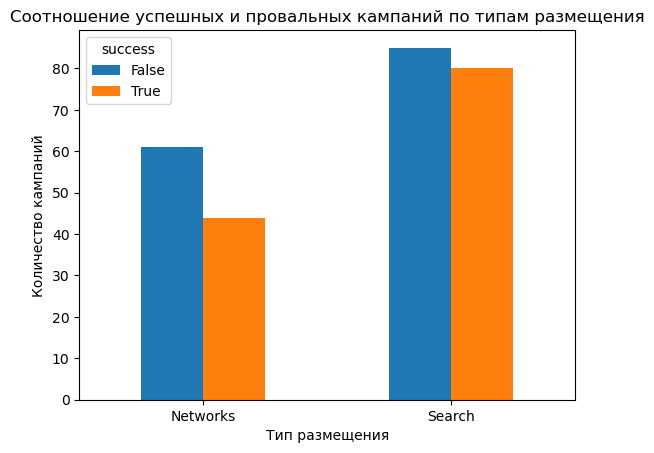

In [31]:
# Строим график соотношения кампаний по типам размещения
data.pivot_table(index='place', columns='success', values='client', aggfunc='count')\
    .plot(kind='bar')
plt.xlabel('Тип размещения')
plt.ylabel('Количество кампаний')
plt.title('Соотношение успешных и провальных кампаний по типам размещения')
plt.xticks(rotation=0);

Разница между провальными и успешными с размещением в поисковике небольшая, опять же провальных больше, на сайтах разница более очевидна, опять же не в пользу успешных

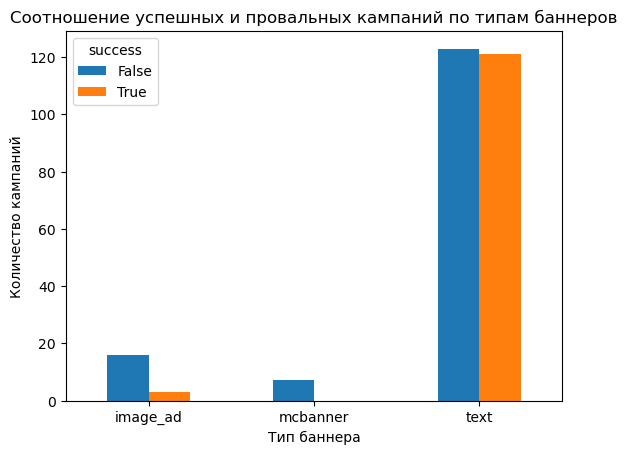

In [32]:
# Строим график соотношения кампаний по типам баннеров
data.pivot_table(index='banner_type', columns='success', values='client', aggfunc='count')\
    .plot(kind='bar')
plt.xlabel('Тип баннера')
plt.ylabel('Количество кампаний')
plt.title('Соотношение успешных и провальных кампаний по типам баннеров')
plt.xticks(rotation=0);

Опять же видим абсолютно провальный тип mcbanner и еще пропал при обработке данных тип cpm_banner, он так и не вышел в свет. Больше провалов ждало и картинки. Текстовые почти равны.

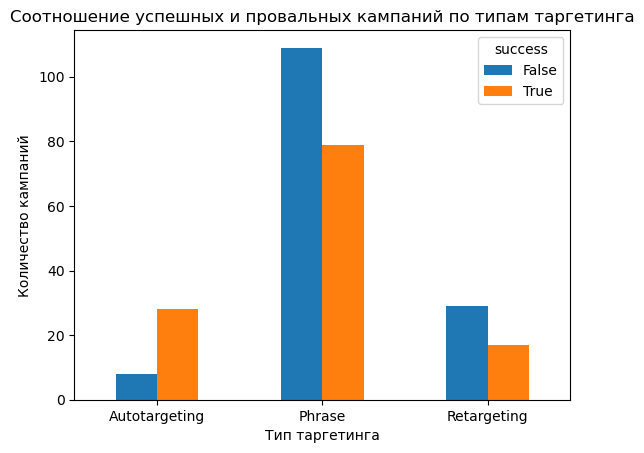

In [33]:
# Строим график соотношения кампаний по типам таргетинга
data.pivot_table(index='targeting_type', columns='success', values='client', aggfunc='count')\
    .plot(kind='bar')
plt.xlabel('Тип таргетинга')
plt.ylabel('Количество кампаний')
plt.title('Соотношение успешных и провальных кампаний по типам таргетинга')
plt.xticks(rotation=0);

Автотаргетинг при правильной настройке почти не давал осечек, и явно лидер, стоит обратить на него внимание в дальнейшем. Остальные же не оправдали ожиданий, возможно стоит обратить внимание на их настройки.

## Общие выводы

Наше исследование проводилось по инициативе компании "Сигма", так как в последние 4 месяца (с июня по сентябрь 2022 года) наблюдался рост показателя CPA по рекламным кампаниям. Входные данные были предоставлены в формате таблицы excel.

__В ходе данного исследования нам удалось ответить на поставленные перед началом исследования вопросы__
- Какова причина растущего CPA?
- Какие действия необходимо предпринять для стабилизации CPA до целевого значения в 380 руб?

__Причина растущего показателя СРА__

Как оказалось, с самого начала были запущены абсолютно убыточные кампании для категории расчетно-кассового обслуживания. В течение 4-х месяцев никто не обращал внимание на убыточность данной категории. Также не совсем понятно как отслеживать конверсию по этой категории услуг, ведь она предполагает личное присутствие в банке. Нужно разбираться с этой категорией.
Также были категории с дебетовыми картами и ипотечным кредитованием стоит рассмотреть типы успешных объявлений для этих категорий и сосредотовчиться на им подобных, потому что они не были полностью провальными, часть из них выстрелила.

__Для стабилизации СРА до 380 рублей необходимо:__

- Исключить рекламные кампании для категории расчетно-кассового обслуживания. Они слишком затратны и не принесли ни одного клиента с СРА ниже или хотябы равным 380 руб.
- Пересмотреть рекламные кампании для категорий с дебетовыми картами и ипотечным кредитованием, выбрать успешные и сделать упор на них в дальнейших кампаний.
- Пересмотреть типы таргетинга, сделать упор на автотаргетинг, он единственный был в плюсе.
- В целом, пересмотреть удачные кампании и на их основе проводить дальнейшие рекламные кампании.